In [ ]:
# PFM VEHICLE COLLISION

## Desde 2011, tras la aprobación de la ley local Nº11, la ciudad de New York publica información relacionada con las colisiones producidas en la ciudad. Esta información se ejecuta manualmente todos los meses y la Unidad TrafficStat revisa la información antes de publicarla en el sitio web del NYPD. 

## En el dataset contiene más de 400k registros. Cada registro representa una colisión en NYC con información de dia y fecha, barrio, cruce de calles, número de heridos, tipo de vehiculos involucrados y los motivos de la colisión.

## Cada año hay más de 170.000 accidentes en la ciudad de NYC en sus cinco distritos: Manhattan, Brooklyn, Staten Island, Bronx y Queens. 
## Los objetivos del análisis de este dataset son: 
   ## - 	Identificar las causas por las que se produce un accidente
   ## - 	Identificar los cruces y zonas más peligrosas
   ## - 	Identificar las zonas más peligrosas o con más colisiones
   ## -	Clasificar las localizaciones a través del algoritmo HDBSCAN


In [2]:
# LIMPIEZA DEL DATASET

# Importación de las bibliotecas necesarias

import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
import calendar
from datetime import datetime
import csv
import reverse_geocoder as rg
import ast

In [3]:
# Cargar del fichero con pandas
data=pd.read_csv('D:/Mireia D/database.csv',sep=',',parse_dates=['DATE','TIME'],low_memory=False)

In [4]:
## Hay 140.000 observaciones sin información de distrito [BOROUGH]. Utilizando algoritmo geocoder reverse, he conseguido completar el 92% de esta información en el dataset, ya que si tenemos las coordenadas de cada observación.
## Elimino también todas las observaciones sin localización ya que el objetivo del análisis es encontrar las localizaciones más seguras y peligrosas. 
data.isnull().sum()

UNIQUE KEY                  0
DATE                        0
TIME                        0
BOROUGH                139342
ZIP CODE               139403
LATITUDE               121132
LONGITUDE              121132
LOCATION               121132
ON STREET NAME         113180
CROSS STREET NAME      142158
OFF STREET NAME        419221
PERSONS INJURED             0
PERSONS KILLED              0
PEDESTRIANS INJURED         0
PEDESTRIANS KILLED          0
CYCLISTS INJURED            0
CYCLISTS KILLED             0
MOTORISTS INJURED           0
MOTORISTS KILLED            0
VEHICLE 1 TYPE           3955
VEHICLE 2 TYPE          80937
VEHICLE 3 TYPE         447468
VEHICLE 4 TYPE         470901
VEHICLE 5 TYPE         476049
VEHICLE 1 FACTOR         3249
VEHICLE 2 FACTOR        62331
VEHICLE 3 FACTOR       446094
VEHICLE 4 FACTOR       470500
VEHICLE 5 FACTOR       475970
dtype: int64

In [5]:
#### Eliminar columnas sin localización
data=data.dropna(subset=['LOCATION'])

In [6]:
#### Crear otro datafame solo con información de localiazción y distrito, y elimino los que sí tienen informado el distrito.
df_geo=data[['LOCATION','BOROUGH']].copy()
df_geo=df_geo[pd.isnull(data['BOROUGH'])]

In [7]:
#### Lista de coordenadas para que el algoritmo busque la información del distrito
coordenadas = df_geo['LOCATION'].values
coordenadas = list(ast.literal_eval(','.join(i.strip() for i in coordenadas)))

In [8]:
#### Aplicar la búsqueda de dirección para las coordenadas de nuestro dataset sin info de distrito
results = rg.search(coordenadas)

Loading formatted geocoded file...


In [9]:
#### Crear fichero para guardar la información del distrito y sus coordenadas
output_filename = 'D:/Mireia D/Distritos.csv'

In [10]:
#### Rellenar fichero Distritos con la informacion de cada distrito dada unas coordenadas
rows = []
for idx, city in enumerate(coordenadas):
    write_row = []
    lat=city[0]
    lon=city[1]
    gdata = results[idx]
    rows.append([lat,lon,gdata['admin2']])
csvwriter = csv.writer(open(output_filename,'w+'),delimiter=' ')
csvwriter.writerows(rows)

In [11]:
#### Cargar el fichero con la info de distrito y la unimos al resto de información por accidente
distrito=pd.read_csv('D:/Mireia D/Distritos.csv',sep=' ',header=None,low_memory=False)
distrito=distrito.rename(columns={0:"LATITUDE",1:"LONGITUDE",2:"BOROUGH",3:"COORDENADAS"})
distrito['COORDENADAS']=[', '.join(str(x) for x in y) for y in map(tuple, distrito[['LATITUDE', 'LONGITUDE']].values)]
distrito=distrito.drop_duplicates(subset=['COORDENADAS'])

In [12]:
#### Eliminar cuando el distrito que devuelve es Hunterdon county ya que sus coordenadas estan fuera de la ciudad de NY
#### Sustituir los barrios que devuelve el algoritmo por los que utiliza el fichero original

distrito=distrito[distrito.BOROUGH != 'Hunterdon County']

distrito=distrito.replace(["Queens County","Nassau County"],'QUEENS')
distrito=distrito.replace(["Kings County",],'BROOKLYN')
distrito=distrito.replace(["New York County","Bergen County"],'MANHATTAN')
distrito=distrito.replace(["Bronx","Westchester County"],'BRONX')
distrito=distrito.replace(["Richmond County","Hudson County","Middlesex County"],'STATEN ISLAND')
distrito[:5]

,LATITUDE,LONGITUDE,BOROUGH,COORDENADAS
0,40.771289,-73.946693,MANHATTAN,"40.7712888, -73.9466928"
1,40.785964,-73.796499,QUEENS,"40.7859639, -73.7964988"
2,40.754864,-73.816832,QUEENS,"40.7548638, -73.8168325"
3,40.602032,-74.187760,STATEN ISLAND,"40.6020321, -74.1877605"
5,40.795539,-73.977228,MANHATTAN,"40.7955388, -73.9772278"


In [13]:
#### Combinar ambos ficheros
result = pd.merge(data, distrito[['LATITUDE','LONGITUDE','BOROUGH']], on=['LATITUDE','LONGITUDE'],how='left')
result[:5]

,UNIQUE KEY,DATE,TIME,BOROUGH_x,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,VEHICLE 2 TYPE,VEHICLE 3 TYPE,VEHICLE 4 TYPE,VEHICLE 5 TYPE,VEHICLE 1 FACTOR,VEHICLE 2 FACTOR,VEHICLE 3 FACTOR,VEHICLE 4 FACTOR,VEHICLE 5 FACTOR,BOROUGH_y
0,3146911,2015-01-01,2018-02-17 00:20:00,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,...,NaN,NaN,NaN,NaN,TRAFFIC CONTROL DISREGARDED,NaN,NaN,NaN,NaN,NaN
1,3146180,2015-01-01,2018-02-17 00:20:00,NaN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,...,NaN,NaN,NaN,NaN,ANIMALS ACTION,NaN,NaN,NaN,NaN,MANHATTAN
2,3146384,2015-01-01,2018-02-17 00:21:00,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,...,UNKNOWN,NaN,NaN,NaN,FATIGUED/DROWSY,UNSPECIFIED,NaN,NaN,NaN,NaN
3,3146013,2015-01-01,2018-02-17 00:30:00,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,...,PASSENGER VEHICLE,NaN,NaN,NaN,LOST CONSCIOUSNESS,NaN,NaN,NaN,NaN,NaN
4,3145968,2015-01-01,2018-02-17 00:51:00,BROOKLYN,11203.0,40.656684,-73.929896,"(40.6566844, -73.9298964)",CLARKSON AVENUE,EAST 51 STREET,...,SPORT UTILITY/STATION WAGON,SPORT UTILITY/STATION WAGON,PASSENGER VEHICLE,NaN,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,NaN,NaN


In [14]:
#### Completar BOROUGH_x con BOROUGH:_y
result.loc[result['BOROUGH_x'].isnull(),'BOROUGH_x']=result.BOROUGH_y
result[:5]

,UNIQUE KEY,DATE,TIME,BOROUGH_x,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,VEHICLE 2 TYPE,VEHICLE 3 TYPE,VEHICLE 4 TYPE,VEHICLE 5 TYPE,VEHICLE 1 FACTOR,VEHICLE 2 FACTOR,VEHICLE 3 FACTOR,VEHICLE 4 FACTOR,VEHICLE 5 FACTOR,BOROUGH_y
0,3146911,2015-01-01,2018-02-17 00:20:00,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,...,NaN,NaN,NaN,NaN,TRAFFIC CONTROL DISREGARDED,NaN,NaN,NaN,NaN,NaN
1,3146180,2015-01-01,2018-02-17 00:20:00,MANHATTAN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,...,NaN,NaN,NaN,NaN,ANIMALS ACTION,NaN,NaN,NaN,NaN,MANHATTAN
2,3146384,2015-01-01,2018-02-17 00:21:00,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,...,UNKNOWN,NaN,NaN,NaN,FATIGUED/DROWSY,UNSPECIFIED,NaN,NaN,NaN,NaN
3,3146013,2015-01-01,2018-02-17 00:30:00,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,...,PASSENGER VEHICLE,NaN,NaN,NaN,LOST CONSCIOUSNESS,NaN,NaN,NaN,NaN,NaN
4,3145968,2015-01-01,2018-02-17 00:51:00,BROOKLYN,11203.0,40.656684,-73.929896,"(40.6566844, -73.9298964)",CLARKSON AVENUE,EAST 51 STREET,...,SPORT UTILITY/STATION WAGON,SPORT UTILITY/STATION WAGON,PASSENGER VEHICLE,NaN,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,NaN,NaN


In [15]:
####Eliminar variable BOROUGH_y del dataframe y renombramos las columnas del dataset
#También eliminamos Person injured y person killed porque ya tenemos otras tres columnas que dan esa misma información de manera desagregada.
result=result.drop(result.columns[[11,12,29]],axis=1)
result.columns=['UNIQUE_KEY','DATE','TIME','BOROUGH','CODE','LATITUDE','LONGITUDE','LOCATION','STREET','CROSS_STREET','OFF_STREET','PEDESTRIAN_INJURED','PEDESTRIAN_KILLED','CYCLIST_INJURED','CYCLIST_KILLED','MOTORIST_INJURED','MOTORIST_KILLED','TYPE_1','TYPE_2','TYPE_3','TYPE_4','TYPE_5','FACTOR_1','FACTOR_2','FACTOR_3','FACTOR_4','FACTOR_5']
#Filtrar coordenadas 0,0
result=result[result.LATITUDE != 0.0] 
result=result[result.LONGITUDE != 0.0]


In [16]:
#### Había 47.602 observaciones sin información de ZIP COCE o BOROUGH. Utilizando algoritmo geocoder reverse, he conseguido completar el 92% de esta información en el dataset
result.isnull().sum()

UNIQUE_KEY                 0
DATE                       0
TIME                       0
BOROUGH                 3926
CODE                   47646
LATITUDE                   0
LONGITUDE                  0
LOCATION                   0
STREET                 78961
CROSS_STREET           84433
OFF_STREET            316378
PEDESTRIAN_INJURED         0
PEDESTRIAN_KILLED          0
CYCLIST_INJURED            0
CYCLIST_KILLED             0
MOTORIST_INJURED           0
MOTORIST_KILLED            0
TYPE_1                  2715
TYPE_2                 58508
TYPE_3                334016
TYPE_4                351550
TYPE_5                355329
FACTOR_1                2673
FACTOR_2               47805
FACTOR_3              333119
FACTOR_4              351305
FACTOR_5              355274
dtype: int64

In [17]:
#### Para analizar si existen dias de la semana, horas del dia o meses más peligrosos, voy a crear estas varaibles en el dataset para facilitar este análissi posterior
df=pd.DataFrame(result)

df['YEAR']=df['DATE'].dt.year
df['MONTH']=df['DATE'].dt.month
df['NAMEMONTH']=df['MONTH'].apply(lambda x: calendar.month_abbr[x])
df['NAMEWEEK']=df['DATE'].dt.weekday_name
df['YEARMONTH'] = df['DATE'].apply(lambda x:x.strftime('%Y-%m'))
df['HOUR']=df['TIME'].dt.hour

In [18]:
## Se crean variables resumen de heridos y fallecidos por tipo de persona involucrada, con la intención de poder analizar mejor esta información 
#### Crear variables que sumen el total de personas heridas y fallecidas segun tipo de persona involucrada en el accidente
df['PEDESTRIAN']=df['PEDESTRIAN_INJURED'] + df['PEDESTRIAN_KILLED']
df['CYCLIST']=df['CYCLIST_INJURED'] + df['CYCLIST_KILLED']
df['MOTORIST']=df['MOTORIST_INJURED'] + df['MOTORIST_KILLED']
#### Crear variable que sume el total de personas heridas y fallecidas independientemente de si es peaton, conductor o ciclista
df['PERSON']=df['PEDESTRIAN'] + df['CYCLIST'] + df['MOTORIST']

In [19]:
## Se crea variable que nos indique el número de vehiculos involucrados en cada accidente 
#### Crear variable que nos indique el número de vehiculos involucrados
type_vehicle=[x for x in df.columns if 'TYPE' in x]
df['N_VEHICLE']=df[type_vehicle].apply(lambda x: x.count(),axis=1)

In [20]:
## Se crea variable que nos inqique la gravedad del accidente
#### clasificando cada accidente en sin heridos, con heridos o con personas fallecidas
heridos=[x for x in df.columns if 'INJURED' in x]
muertes=[x for x in df.columns if 'KILLED' in x]
df['GRAVEDAD']='Sin_heridos'
df.loc[df[muertes].sum(axis=1)>0,'GRAVEDAD']='Muertes'
df.loc[(df[muertes].sum(axis=1)==0)&(df[heridos].sum(axis=1)>0),'GRAVEDAD']='Heridos'
df.GRAVEDAD.value_counts()

Sin_heridos    292200
Heridos         64056
Muertes           329
Name: GRAVEDAD, dtype: int64

In [21]:
## Normalización de los tipos de vehiculos
#### Renombrar algunos tipo de vehiculo mal escritos y cambiar a mayusculas
for columns in df[type_vehicle]:
    df[type_vehicle]=df[type_vehicle].apply(lambda col:col.str.upper())
    df[type_vehicle]=df[type_vehicle].replace(["ABULA","AM","AMB","AMBUL","AR"],'AMBULANCE')
    df[type_vehicle]=df[type_vehicle].replace(["BU","BSD"],'BUS')
    df[type_vehicle]=df[type_vehicle].replace(["FB","FDNY","FIRET","FIRE"],'FIRE TRUCK')
    df[type_vehicle]=df[type_vehicle].replace(["SCOOTER","MOTOR"],'MOTORCYCLE')

In [22]:
## Normalización de las calles
STREET_GROUP=[x for x in df.columns if 'STREET' in x]
for columns in df[STREET_GROUP]:
    df[STREET_GROUP]=df[STREET_GROUP].apply(lambda col:col.str.upper())

normalization_street={'AVENUE':'AV',
    'AVE':'AV',
    'AVNUE': 'AV',
    'STREET': 'ST',
    'ROAD': 'RD',
    'BOULEVARD': 'BLVD',
    'PLACE': 'PL',
    'PLAZA': 'PL',
    'SQUARE': 'SQ',
    'DRIVE': 'DR',
    'LANE': 'LN',
    'PARKWAY': 'PKWY',
    'TURNPIKE': 'TP',
    'TERRACE': 'TER',
    '1ST': '1',
    '2ND':'2',
    '3RD': '3',
    '1TH': '1',
    '2TH': '2',
    '3TH': '3',
    '4TH': '4',
    '5TH': '5',
    '6TH': '6',
    '7TH': '7', 
    '8TH': '8',
    '9TH': '9',
    '0TH': '0',              
    'WEST ': 'W ',
    'NORTH ': 'N ',
    'EAST ': 'E ',
    'SOUTH ': 'S '}

#### Realizar reemplazo con los valores de normalización
for column in STREET_GROUP:
    df[STREET_GROUP]=df[STREET_GROUP].replace(normalization_street,regex=True)

In [23]:
# ANÁLISIS EXPLORATORIO 
## ¿Cuales son los tipos de vehiculo más involucrados en accidentes?

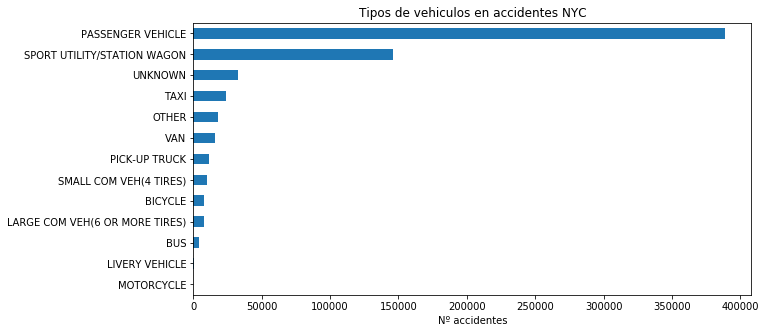

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
df_type = pd.DataFrame([df.loc[:,x].value_counts().nlargest(10) for x in type_vehicle]).fillna(0).sum().sort_values(ascending=True)
df_type.plot(kind='barh',ax=ax)
ax.set_title('Tipos de vehiculos en accidentes NYC')
ax.set_xlabel('Nº accidentes')
plt.show()
